# Lecture 3-9: Image Segmentation

## 0.- Initialize filesystem and libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from IPython.display import Image, display

In [ ]:
!pip install pydicom
import pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 32.7 MB/s eta 0:00:00


## 1.- Introduction to Segmentation

Image segmentation is the process in image processing where an image is **divided into multiple local segments or regions**, which can be defined as **sets of pixels that shares similar characteristics** such as grayscale or color intensity, texture, shape, etc.

Its main **goal** is to simplify or change the representation of an image into something more meaningful and easier to analyze (object-based instead of pixel-based). This process is typically used to **identify objects or boundaries** (lines, curves, etc.) within images, which **separate** one region from another.

The **result** of segmentation is usually a **set of segments** that cover the entire image, or a **set of contours** extracted from the image.

There are various methods for performing image segmentation:

* **Threshold-based** segmentation: separates pixels based on intensity values.

* **Edge-based** methods: detects object boundaries by identifying significant changes in intensity.

* **Active contour** models: use a deformable model approach to detect edges and boundaries, being more flexible and adaptive than edge-based methods.

* **Clustering-based** algorithms: groups pixels into clusters based on their attributes.

* **Region-based** techniques (morphological watersheds): regions are defined by growing areas of similarity.

## 2.- Threshold-Based Segmentation

Threshold-based segmentation relies on determining a specific value (**threshold**) extracted from the histogram.

### 2.1. Global thresholding

The most basic threshold-based technique is based on one fixed **global threshold** for the entire image.

Each pixel in the image is compared with the threshold value:

- if the pixel value is equal or **higher** than the threshold, it is assigned to **1**, and it is considered **object point**
- if the pixel intensity is **lower**, then that pixel is set to **0**, and it is considered **background point**

$$
g(x, y) =
\begin{cases}
1 & \text{if } f(x, y) \geq T \\
0 & \text{if } f(x, y) < T
\end{cases}
$$

However, setting a **unique and global value** for the entire image is **difficult** and usually does not generate acceptable results.

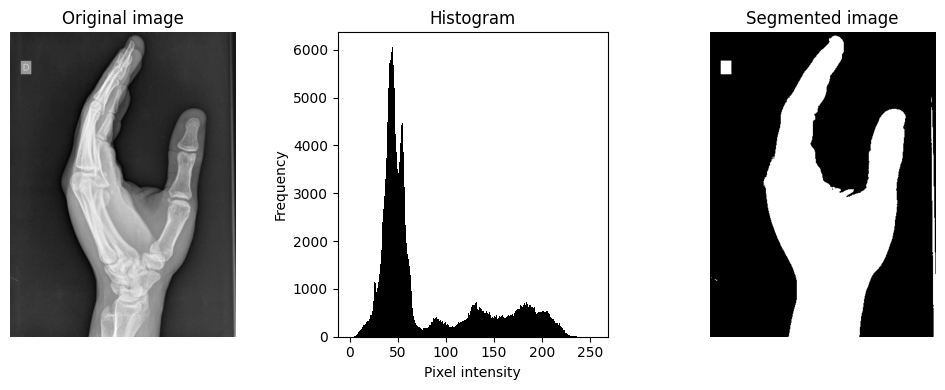

In [ ]:
# Load the image in grayscale
image_path = '/content/drive/MyDrive/PIM/Images/X-ray_3.png'
grayscale_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Define a global threshold value
threshold_value = 75

# Apply binary thresholding
_, segmented_image = cv2.threshold(grayscale_image, threshold_value, 255, cv2.THRESH_BINARY)

# Plot the original image, histogram, and segmented image
plt.figure(figsize=(10, 4))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(grayscale_image, cmap='gray')
plt.title('Original image')
plt.axis('off')

# Histogram
plt.subplot(1, 3, 2)
plt.hist(grayscale_image.flatten(), bins=256, range=[0, 256], color='black')
plt.title('Histogram')
plt.xlabel('Pixel intensity')
plt.ylabel('Frequency')

# Segmented image
plt.subplot(1, 3, 3)
plt.imshow(segmented_image, cmap='gray')
plt.title('Segmented image')
plt.axis('off')

plt.tight_layout()
plt.show()

#### **Effect of noise on image thresholding**

Even for straightforward images, **noise can distort the histogram**, complicating the process of setting a threshold. This happens even when visually distinguishing between objects and the background remains relatively easy.

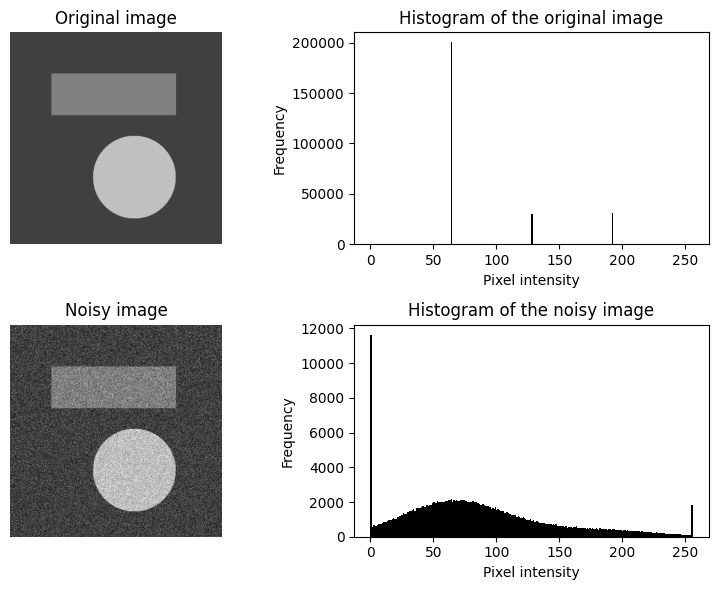

In [ ]:
# Create a synthetic image with background intensity 64
image = np.full((512, 512), 64, dtype=np.uint8)

# Create the first object with intensity 128
cv2.rectangle(image, (100, 100), (400, 200), 128, -1)  # Rectangle with intensity 128

# Create the second object with intensity 192
cv2.circle(image, (300, 350), 100, 192, -1)  # Circle with intensity 192

# Add Gaussian noise to the image
mean = 0
sigma = 40
# - mean: average value of the Gaussian distribution
# - sigma: standard deviation of the Gaussian distribution
# - image.shape: defines the shape of the array of random noise values to generate
gaussian_noise = np.random.normal(mean, sigma, image.shape)

# Add the noise to the image and clip to ensure values are within [0, 255]
# Casting to uint8 should be done after clipping to avoid wrapping (-1 -> 255, or 256 -> 0)
noisy_image = np.clip(image + gaussian_noise, 0, 255).astype(np.uint8)

# Plot the original image, its histogram, the noisy image, and its histogram
plt.figure(figsize=(8, 6))

# Original image
plt.subplot(2, 2, 1)
plt.imshow(image, cmap='gray', vmin=0, vmax=255)
plt.title('Original image')
plt.axis('off')

# Histogram of original image
plt.subplot(2, 2, 2)
plt.hist(image.flatten(), bins=256, range=[0, 256], color='black')
plt.title('Histogram of the original image')
plt.xlabel('Pixel intensity')
plt.ylabel('Frequency')

# Noisy image
plt.subplot(2, 2, 3)
plt.imshow(noisy_image, cmap='gray', vmin=0, vmax=255)
plt.title('Noisy image')
plt.axis('off')

# Histogram of noisy image
plt.subplot(2, 2, 4)
plt.hist(noisy_image.flatten(), bins=256, range=[0, 256], color='black')
plt.title('Histogram of the noisy image')
plt.xlabel('Pixel intensity')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

**Smoothing** can be used to **denoise** an image and thus **facilitate** the determination of a **threshold** from the histogram.

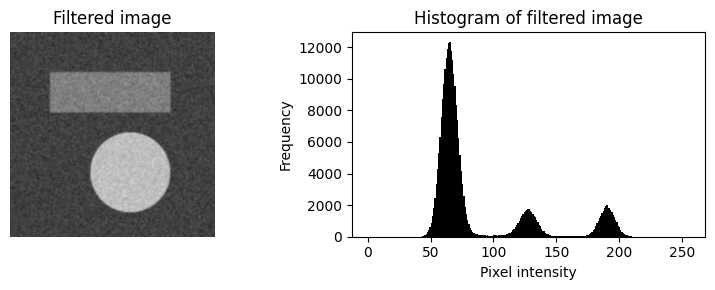

In [ ]:
# Apply Gaussian spatial filtering to the noisy image
# - ksize = (9, 9): kernel size (odd number)
# - sigmaX = 0: standard deviation of the Gaussian distribution
#   0 means that OpenCV will automatically calculate the best value based on the kernel size
filtered_image = cv2.GaussianBlur(noisy_image, (9, 9), 0)

# Plot the denoised image and its histogram
plt.figure(figsize=(8, 3))

# Filtered image
plt.subplot(1, 2, 1)
plt.imshow(filtered_image, cmap='gray', vmin=0, vmax=255)
plt.title('Filtered image')
plt.axis('off')

# Histogram of filtered image
plt.subplot(1, 2, 2)
plt.hist(filtered_image.flatten(), bins=256, range=[0, 256], color='black')
plt.title('Histogram of filtered image')
plt.xlabel('Pixel intensity')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### 2.2. Multiple thresholds

Depending on the image and its histogram, maybe one threshold does not provide good results. In that case **multiple thresholds** can be used:

$$
g(x, y) =
\begin{cases}
a & \text{if } f(x, y) > T_2 \\
b & \text{if } T_1 < f(x, y) \leq T_2 \\
c & \text{if } f(x, y) \leq T_1
\end{cases}
$$

where $a$, $b$, $c$ are arbitrary values to represent **each range of gray levels** with an intensity level, each one corresponding to an **object**.

However, setting **more than 2-3 thresholds** is still difficult and **not practical** for the majority of images, thus requiring of more advanced techniques.

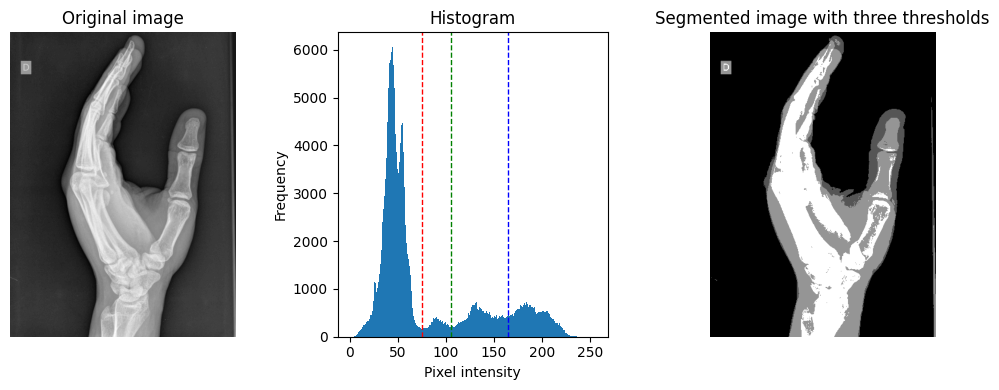

In [ ]:
# Load the image in grayscale
image_path = '/content/drive/MyDrive/PIM/Images/X-ray_3.png'
grayscale_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Define three threshold values
T1 = 75
T2 = 105
T3 = 165

# Create an array with the same size of the image, filled with zeros
segmented_image = np.zeros_like(grayscale_image)

# Apply multiple thresholding to segment the image into four regions

# Region 1: below T1
# grayscale_image <= T1: returns a Boolean mask, where each element is True if
# the corresponding pixel intensity is less than or equal to T1, and False otherwise
segmented_image[grayscale_image <= T1] = 30  # Assign an arbitrary intensity value for visualization

# Region 2: between T1 and T2 (assign an arbitrary intensity value for visualization)
segmented_image[(grayscale_image > T1) & (grayscale_image <= T2)] = 90

# Region 3: between T2 and T3
segmented_image[(grayscale_image > T2) & (grayscale_image <= T3)] = 135

# Region 4: above T3 (assign the maximum intensity value for visualization)
segmented_image[grayscale_image > T3] = 210

# Plot the original image, histogram, and segmented image
plt.figure(figsize=(10, 4))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(grayscale_image, cmap='gray')
plt.title('Original image')
plt.axis('off')

# Histogram
plt.subplot(1, 3, 2)
plt.hist(grayscale_image.flatten(), bins=256, range=[0, 256])
# plt.axvline(x, color, linestyle, linewidth)
# - x: x-coordinate at which the vertical line is drawn
# - color: color of the line (optional, default is black)
# - linestyle: style of the line (solid ('-'), dashed ('--'), ...); it is optional
# - linewidth: width of the line in points (optional)
plt.axvline(T1, color='r', linestyle='dashed', linewidth=1) # red dashed vertical line at x = T1
plt.axvline(T2, color='g', linestyle='dashed', linewidth=1)
plt.axvline(T3, color='b', linestyle='dashed', linewidth=1)
plt.title('Histogram')
plt.xlabel('Pixel intensity')
plt.ylabel('Frequency')

# Segmented image
plt.subplot(1, 3, 3)
plt.imshow(segmented_image, cmap='gray')
plt.title('Segmented image with three thresholds')
plt.axis('off')

plt.tight_layout()
plt.show()

### 2.3. Optimum global thresholding

Finding the **optimum value for global thresholding** in **bimodal histograms** (histograms that contains two bell-shaped peaks separated by a valley) is usually done with the **Otsu's method**. In these cases, one of the **peaks** (or classes) is associated with the **background** and the other with the **objects**.

This algorithm basically **iterates** through all possible threshold values and find the **optimal value** that of **maximizes the inter-class variance** (or minimizes the intra-class variance, which is equivalent) in the histogram. That is, this method sets a threshold value that provides the **best separation between classes** or objects in terms of their intensity values.

The Otsu's algorithm consists of the following steps:

1. Calculate the **histogram** of the image.
2. Calculate the **total mean intensity level** for the entire image.
3. **Iterate** through all possible threshold values:
	*	For each threshold, **separate** the pixels into two classes: **background** (pixel intensities below the threshold) and **foreground** (intensities above)
	*	Compute the **mean intensity** and the **intra-class variance** of each class for this threshold.
4. **Select** the threshold that **minimizes** the intra-class variance, which is considered the **optimal threshold** for segmenting the image.

**Mathematical foundations of the Otsu's method**

Mathematically, the algorithm starts with the **total number of pixels** in the image, $N$, and the **normalized histogram** of the image, represented as $p(i)$, where $i$ is the intensity level and $p(i)$ is the probability of that intensity level occurring in the image.

The probability of each intensity level $i$ can be expressed as:

$$p(i) = \frac{n_i}{N}$$

where $n_i$ is the number of pixels with intensity $i$.

The algorithm computes the **intra-class variance** $\sigma^2_w(T)$ **for a threshold** $T$ as follows:

1. Compute the **weight** for the background class $\omega_b(T)$ and the foreground class $\omega_f(T)$:
$$
\omega_b(T) = \sum_{i=0}^{T} p(i)
$$
$$
\omega_f(T) = \sum_{i=T+1}^{L-1} p(i)
$$
where $L$ is the total number of intensity levels.

2. Compute the **mean intensity** for the background class $\mu_b(T)$ and the foreground class $\mu_f(T)$:
$$
\mu_b(T) = \dfrac{\sum_{i=0}^{T} i \cdot p(i)}{\omega_b(T)}
$$
$$
\mu_f(T) = \dfrac{\sum_{i=T+1}^{L-1} i \cdot p(i)}{\omega_f(T)}
$$

3. The **intra-class variance** $\sigma^2_w(T)$ is given by:
$$
\sigma^2_w(T) = \omega_b(T) \cdot \sigma_b^2(T) + \omega_f(T) \cdot \sigma_f^2(T)
$$
where $\sigma_b^2(T)$ and $\sigma_f^2(T)$ are the variances of the two classes.

4. The threshold $T$ that minimizes the intra-class variance is chosen as the **optimal threshold**:
$$
\sigma_B(T) = \sigma^2-\sigma_w^2(T) = \omega_b(T)\,\omega_f(T)\,[\mu_b(T)-\mu_f(T)]^2
$$
where $\sigma^2$ is the variance of the whole image and $\sigma_B^2$ is the inter-class variance.

Optimal threshold (Otsu's method): 106.0


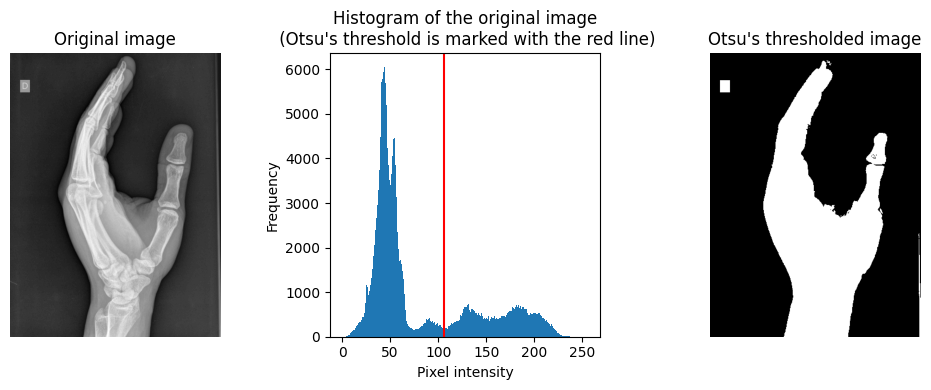

In [ ]:
# Load the image in grayscale
image_path = '/content/drive/MyDrive/PIM/Images/X-ray_3.png'
grayscale_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Apply Otsu's thresholding
# cv2.THRESH_BINARY + cv2.THRESH_OTSU indicates:
#	-	cv2.THRESH_BINARY: apply binary thresholding (clipping to 0 or 255)
#	-	cv2.THRESH_OTSU: automatically determine the optimal threshold using Otsu’s method
otsu_threshold, otsu_thresholded_image = cv2.threshold(grayscale_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
print(f"Optimal threshold (Otsu's method): {otsu_threshold}")

# Plot the original image, its histogram, and the Otsu-thresholded image
plt.figure(figsize=(10, 4))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(grayscale_image, cmap='gray')
plt.title('Original image')
plt.axis('off')

# Histogram
plt.subplot(1, 3, 2)
plt.hist(grayscale_image.flatten(), bins=256, range=[0, 256])
plt.title("Histogram of the original image\n (Otsu's threshold is marked with the red line)")
plt.xlabel('Pixel intensity')
plt.ylabel('Frequency')
plt.axvline(otsu_threshold, color='r')  # Otsu's threshold

# Otsu's thresholded image
plt.subplot(1, 3, 3)
plt.imshow(otsu_thresholded_image, cmap='gray')
plt.title("Otsu's thresholded image")
plt.axis('off')

plt.tight_layout()
plt.show()

### 2.4. Multi-Otsu Thresholding

Multi-Otsu thresholding is an **extension of the Otsu's method**, allowing for segmentation into **multiple classes** rather than just two.

It is based on the same principle as the Otsu's method, **maximizing the inter-class variance**, but in this case, **using multiple thresholds for more than 2 classes**.

For a given set of thresholds $\{T_1, T_2, \ldots, T_{n-1}\}$ that divides the pixel intensity range into $n$ classes, the inter-class variance is defined as:

$$\sigma_B^2 = \sum_{i=1}^n w_i (\mu_i - \mu_T)^2$$

where:

* $w_i$ is the weight of class $i$, calculated as the probability of the class,
* $\mu_i$ is the mean intensity of class $i$,
* $\mu_T$ is the mean intensity of the entire image.

The algorithm searches for the **set of thresholds that maximizes** $\sigma_B^2$, thus ensuring that the classes are as distinct as possible.

Thresholds:  [ 69 117 166]
[[1 1 1 1 1 1 2 2 2 2]
 [1 1 1 1 1 2 3 3 2 2]
 [1 1 1 1 1 2 3 2 2 2]
 [1 1 1 1 2 2 2 2 2 2]
 [1 1 1 1 2 2 2 2 2 2]
 [1 1 1 2 2 2 2 2 2 1]
 [1 1 1 2 2 2 2 2 2 2]
 [1 1 2 2 2 2 2 2 2 2]
 [1 1 2 2 2 2 2 2 2 2]
 [1 2 3 2 2 2 2 2 3 3]]


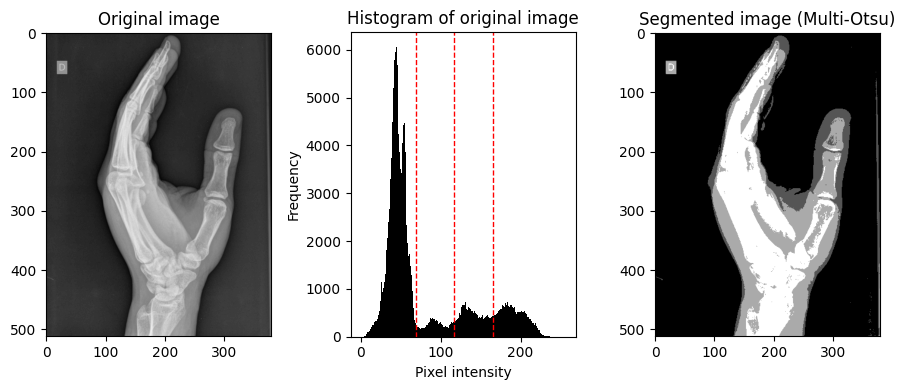

In [ ]:
from skimage.filters import threshold_multiotsu

# Load the grayscale image
image_path = '/content/drive/MyDrive/PIM/Images/X-ray_3.png'
grayscale_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Apply multi-Otsu thresholding
thresholds = threshold_multiotsu(grayscale_image, classes=4)  # classes indicates the number of different classes
print("Thresholds: ", thresholds)

# Digitize the image based on the thresholds
# np.digitize assigns pixel values in the image to different regions (or bins) based on a set of thresholds
# - grayscale_image: input grayscale image
# - thresholds: array of threshold values that define the boundaries between different regions
# - regions:  the result of the function, where each pixel is assigned to a class or region
regions = np.digitize(grayscale_image, bins=thresholds)
print(regions[20:30, 195:205])

# Plot the original image, its histogram, and the segmented image
plt.figure(figsize=(9, 4))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(grayscale_image, cmap='gray', vmin=0, vmax=255)
plt.title('Original image')

# Histogram of original image
plt.subplot(1, 3, 2)
plt.hist(grayscale_image.flatten(), bins=256, range=[0, 256], color='black')
plt.title('Histogram of original image')
plt.xlabel('Pixel intensity')
plt.ylabel('Frequency')
for i in range(len(thresholds)):
  plt.axvline(thresholds[i], color='r', linestyle='dashed', linewidth=1)

# Segmented image
plt.subplot(1, 3, 3)
plt.imshow(regions, cmap='gray')
plt.title('Segmented image (Multi-Otsu)')

plt.tight_layout()
plt.show()

## 3.- Edge-Based Segmentation


###	3.1. Canny filter


The Canny filter is one of the most common algorithms for **edge detection** in images. It is known for its ability to detect a **wide range** of edges in images accurately and for its **robustness to noise**.

The algorithm depends on three **parameters**:

* **standard deviation** ($\sigma$) of the Gaussian filter: controls the amount of **smoothing** applied to the image (the higher the sigma value, the smoother the image).
* **low** ($t_1$) and **high** ($t_2$) **thresholds** to apply **hysteresis** for detecting edges.

The algorithm consists of these **steps**:

1. Noise reduction and **image smoothing** using a Gaussian blur, to prevent false edge detection caused by noise.

2. **Gradient calculation** (intensity and direction) in in the horizontal ($g_x$) and vertical ($g_y$) directions using Sobel filters:
$$
G = \sqrt{g_x^2+g_y^2}
$$
$$
\theta = \arctan\left(\dfrac{g_y}{g_x}\right)
$$

3. **Non-maximum suppression** to find out the edges. For every pixel, the algorithm checks if it is a local maximum in the direction of the gradient; if it is not, it is set to zero. In this way, only the **local maxima** along the gradient direction are retained.

<img src="https://docs.opencv.org/4.x/nms.jpg" alt="Caption" width="500">
<p style="text-align: center;">Figure 1: Candidate points to local maximum along the gradient direction in the Canny filter. Source: <a href="https://docs.opencv.org/4.x/da/d22/tutorial_py_canny.html">OpenCV.</a></p>

4. **Two thresholds** are applied, in order to **classify edges into strong, weak, and non-relevant**. Pixels with gradient magnitudes above the high threshold are considered strong edges, while those between the low and high thresholds are considered weak edges. Pixels below the low threshold are removed (non-relevant).

<img src="https://docs.opencv.org/4.x/hysteresis.jpg" alt="Caption" width="500">
<p style="text-align: center;">Figure 2: Hysteresis thresholding in Canny filter to classify the points into strong, weak, and non-relevant. Source: <a href="https://docs.opencv.org/4.x/da/d22/tutorial_py_canny.html">OpenCV.</a></p>

5. The algorithm **iterates over the weak edges** and include them in the **edge map** only if they are **connected** to any strong edge. **Strong edges** are immediately **included** in the final edge map. This ensures that the **detected edges are all connected**, reducing the likelihood of fragmented edges.

The result of the Canny filter is a **binary image**, where every pixel has a value of 0 (no edge) or 255 (edge).

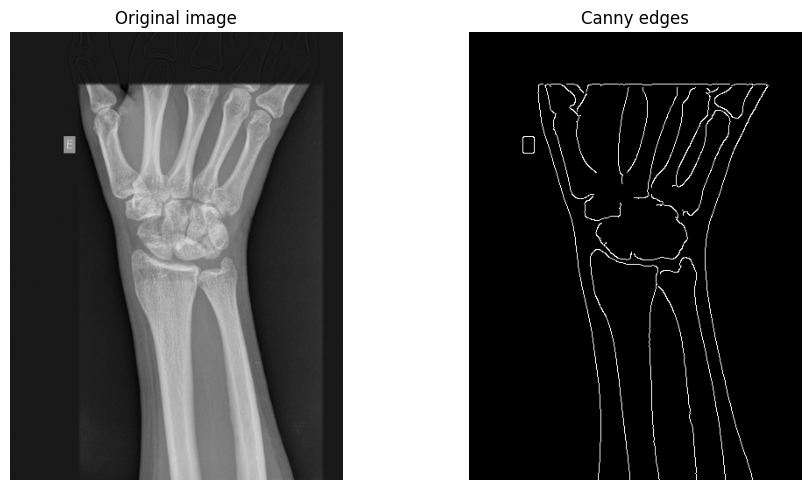

In [ ]:
# Load an image
image_path = '/content/drive/MyDrive/PIM/Images/X-ray_2.png'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Parameters for Canny edge detector
kernel_size = 5
sigma = 1.5
threshold1 = 50
threshold2 = 150

# Apply Gaussian Blur with the specified sigma
blurred_image = cv2.GaussianBlur(image, (kernel_size, kernel_size), sigma)

# Apply Canny edge detector
edges = cv2.Canny(blurred_image, threshold1, threshold2)

# Display the results
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original image")
plt.imshow(image, cmap='gray', vmin=0, vmax=255)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Canny edges")
plt.imshow(edges, cmap='gray', vmin=0, vmax=255)
plt.axis('off')

plt.tight_layout()
plt.show()

### 3.2. Hough Transform

The Hough Transform is a technique used for **detecting straight lines** in an image, although it was later generalized to detect also circles and other simple geometric shapes.

It can be used as **part of a segmentation workflow** by detecting these shapes and then using the detected shapes to define **regions of interest (ROIs)** that can be segmented from the rest of the image.

This method **converts the problem of detecting shapes in the image space into a problem of finding intersecting curves in a parameter space**, making it **robust** against noise and imperfections, like partially occluded shapes.

The Hough Transform works by **mapping points from the image space to a parameter space** where each shape (e.g., line, circle) can be represented by a **parameterized equation**.

A **line** in Cartesian coordinates can be represented by the equation $y = mx + b$ , where $m$ is the slope and $b$ is the intercept with the $y$ axis. However, in the case of vertical lines, $m$ is infinite, so it is more convenient to use **polar coordinates**:

$$\rho = x \cos \theta + y \sin \theta$$

where:

* $\rho$ is the distance from the origin to the closest point on the line
* $\theta$ is the angle between the x-axis and the line perpendicular to the detected line

<img src="https://miro.medium.com/v2/resize:fit:824/format:webp/0*VAXB92TCIKUfTBhR.jpg" alt="Caption" width="400">
<p style="text-align: center;">Figure 3: Point defined in both Cartesian and polar coordinates. Source: <a href="https://medium.com/@tomasz.kacmajor/hough-lines-transform-explained-645feda072ab">Medium.com.</a></p>

In this way, **a straight line** in the image space or Cartesian space **can be represented as a point** in polar coordinates (also known as the _accumulator plane_ or the _Hough space_), defined by ($\rho, \theta$).

<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/0*M6izxOsRBBKlkZzq.jpg" alt="Caption" width="800">
<p style="text-align: center;">Figure 4: Straight line in image space represented as a point in polar coordinates (related to the Hough space). Source: <a href="https://medium.com/@tomasz.kacmajor/hough-lines-transform-explained-645feda072ab">Medium.com.</a></p>

A set of lines that intersect at the same point $(x, y)$ in Cartesian space correspond to points in the Hough space that form sinusoids. This is equivalent to say that **a point** in Cartesian space **corresponds to a sinusoid** in the Hough space.

<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/0*JT-hhPkp-Tx4ywtu.jpg" alt="Caption" width="800">
<p style="text-align: center;">Figure 5: Multiple lines that intersect in the same point in the Cartesian space correspond to points that form a sinusoid in polar coordinates. Source: <a href="https://medium.com/@tomasz.kacmajor/hough-lines-transform-explained-645feda072ab">Medium.com.</a></p>

Indeed, for fixed $(x, y)$ values and a varying angle $\theta$ in the equation $\rho = x \cos(\theta) + y \sin(\theta)$, $\rho(\theta)$ describes a sinusoid.

<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/0*pJDI5sW6oEBDQQqd.jpg" alt="Caption" width="800">
<p style="text-align: center;">Figure 6: A point in the Cartesian space corresponds to a sinusoid in the Hough space. Source: <a href="https://medium.com/@tomasz.kacmajor/hough-lines-transform-explained-645feda072ab">Medium.com.</a></p>

Based on this, **several points lying on the same straight line** in Cartesian space **correspond to several sinusoids that intersect at the same point** $(\rho, \theta)$ in the Hough space, which can be identified as a peak.

<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/0*VPVsLApWiEayRGdQ.jpg" alt="Caption" width="800">
<p style="text-align: center;">Figure 7: Several points lying on the same straight line in Cartesian space correspond to several sinusoids that intersect at the same point in the Hough space. Source: <a href="https://medium.com/@tomasz.kacmajor/hough-lines-transform-explained-645feda072ab">Medium.com.</a></p>

Thus, **the problem of detecting complex shapes in an image is then transformed into a problem of finding peaks in a simpler space** (the parameter or Hough space), which makes it very **robust to noise or partially defined shapes**.


The main **steps** of the Hough Transform algorithm are then as follows:

1. **Edge detection**: preprocess the image to highlight the edges, using an edge detection algorithm like Canny, Sobel, or Prewitt. The resulting edge map indicates where **potential shapes** may exist.

2. **Parameter space representation**: transform the edge points from the image space into a parameter space in polar coordinates.

3. **Voting in the Accumulator**:	for each edge **point**, a **vote** is registered in the accumulator space by incrementing the corresponding parameters ($\rho$,  $\theta$). This process creates **peaks** in the accumulator space where many votes intersect, corresponding to the presence of a **shape** in the image.

4. **Detecting peaks**: analyze the accumulator space to detect **significant peaks**, which correspond to the most likely **shapes** present in the image. The coordinates of these peaks give the parameters of the detected shapes.

5. **Shape reconstruction**: use the detected parameters to **reconstruct the shapes** (e.g., lines, circles) in the original image space.

The Hough Transform is used to **detect lines**, but it **does not** automatically **find the intersections** between them. However, with the line parameters $(\rho, \theta)$, it is possible to **revert to the original coordinates and calculate the intersections** manually or by using an additional algorithm.”

Detected 6 lines.
Line detected with rho=50.0, theta=1.57 (degrees 90.00)
Line detected with rho=50.0, theta=0.00 (degrees 0.00)
Line detected with rho=51.0, theta=1.55 (degrees 89.00)
Line detected with rho=49.0, theta=1.59 (degrees 91.00)
Line detected with rho=51.0, theta=0.02 (degrees 1.00)
Line detected with rho=-49.0, theta=3.12 (degrees 179.00)


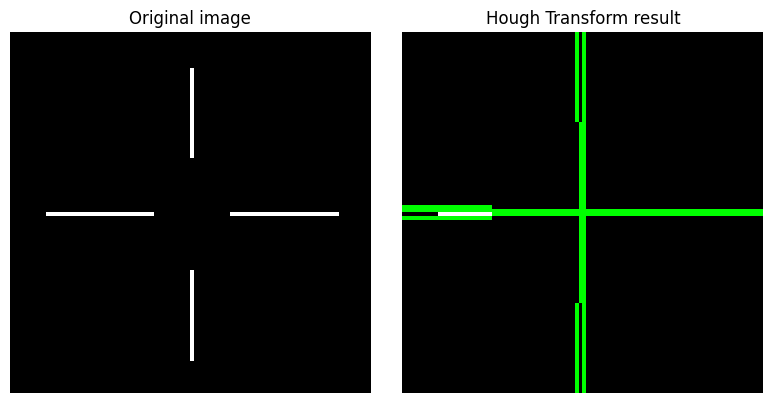

In [ ]:
# Create a black image with a white horizontal line
image = np.zeros((100, 100), dtype=np.uint8)
cv2.line(image, (10, 50), (90, 50), 255, 1)  # Draw a white line
cv2.line(image, (50, 10), (50, 90), 255, 1)  # Draw a white line
cv2.rectangle(image, (40, 35), (60, 65), (0, 0, 0), -1) # Draw a black square in the center

# Apply the Hough Transform to detect lines
# - image: binary image (after applying edge detection such as Canny filter) in uint8 format
# - distance resolution of the accumulator in pixels: represents how precisely
#   rho distaince will be measured (a value of 1 means the function will search
#   for lines in 1-pixel increments in the \rho dimension)
# - angular resolution of the accumulator in radians: represents how finely the angle
#   will be measured (pi / 180 means that the function will search for ines with an
#   angular resolution of 1 degree (= pi / 180); smaller values give finer
#   angular resolution but increase the computational cost
# - threshold: minimum number of intersections (votes) needed to detect a line;
#	  lower values make it easier to detect lines.
lines = cv2.HoughLines(image, 1, np.pi / 180, 25)

# Print out the lines detected
if lines is not None:
    print(f"Detected {len(lines)} lines.")
    for line in lines:
        rho, theta = line[0]
        print(f"Line detected with rho={rho}, theta={theta:.2f} (degrees {np.degrees(theta):.2f})")
else:
    print("No lines detected.")

# Draw the lines detected by the Hough Transform
hough_image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)  # Convert to RGB for color display
if lines is not None:
    for rho, theta in lines[:, 0]: # each line is represented by parameters rho and theta
        a = np.cos(theta)
        b = np.sin(theta)
        # (x0, y0) is a point on the line in Cartesian space, calculated from the Hough space parameters (rho, theta)
        x0 = a * rho
        y0 = b * rho
        # Compute two points for the line, (x1, y1) and (x2, y2), from polar coordinates
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        cv2.line(hough_image, (x1, y1), (x2, y2), (0, 255, 0), 1)  # Draw the line in green

# Plot the results
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title("Original image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(hough_image)
plt.title("Hough Transform result")
plt.axis('off')

plt.tight_layout()
plt.show()

Detected 15 lines.


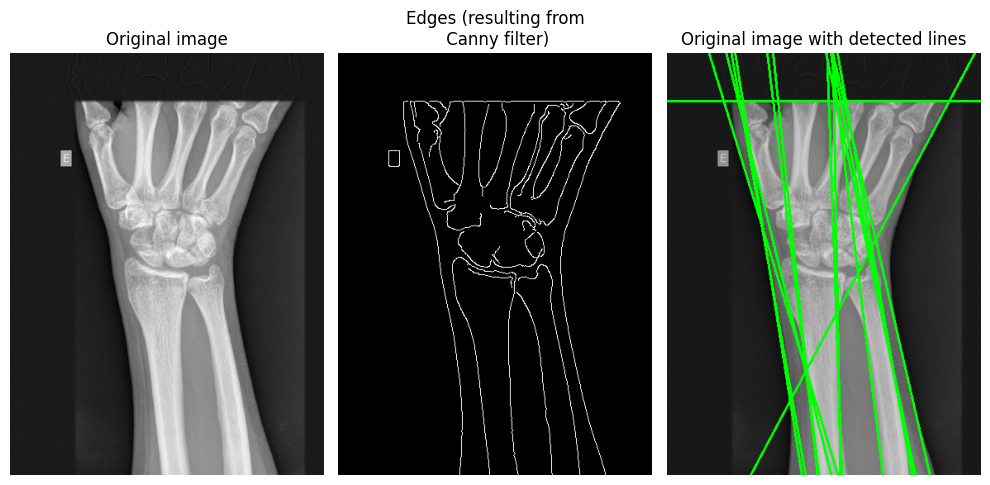

In [ ]:
# Load the image
image_path = '/content/drive/MyDrive/PIM/Images/X-ray_2.png'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Apply Gaussian Blur to reduce noise
blurred_image = cv2.GaussianBlur(image, (5, 5), 0)

# Apply edge detection using Canny
edges = cv2.Canny(blurred_image, threshold1=50, threshold2=150)

# Apply the Hough Transform to detect lines
lines = cv2.HoughLines(edges, 1, np.pi / 180, 90)
if lines is not None:
    print(f"Detected {len(lines)} lines.")
else:
    print("No lines detected.")

# Create a mask to store the lines detected by the Hough Transform
mask = np.zeros_like(image)

# Create a copy of the original image to draw the detected lines on it
image_with_lines = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)  # Convert to RGB for color display

# Draw the lines detected by the Hough Transform on the mask and the original image
if lines is not None:
    for rho, theta in lines[:, 0]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))

        # Draw lines in white on the mask (binary)
        cv2.line(mask, (x1, y1), (x2, y2), 255, 1)

        # Draw lines in green on the original image with lines
        cv2.line(image_with_lines, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green lines

# Use the mask to highlight the detected lines on the original image
highlighted_image = cv2.bitwise_and(image, mask)

# Plot the results
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title("Original image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(edges, cmap='gray')
plt.title("Edges (resulting from\n Canny filter)")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(image_with_lines)
plt.title("Original image with detected lines")
plt.axis('off')

plt.tight_layout()
plt.show()

### 3.3. Contour tracing

Contours are curves that **connect all continuous points along a boundary with the same color or intensity** in an image.

The `cv2.findContours` function in OpenCV is used to extract contours from **binarized images**, where foreground objects (1) are distinguished from the background (0).

This function implements the Suzuki-Abe algorithm, which works by **iterating** through all pixels in the binary image and **identifying contours** by **following the edges** between foreground and background.

Once a contour is detected, the algorithm **traces the boundary** by moving to adjacent pixels, **storing the coordinates** of the contour points. These points can be organized **hierarchically**, identifying **relationships** between nested contours.

The steps of this algorithm include:

1. **Binary image input**: the input image should be a  binary image, generated through thresholding.
2. **Edge tracing**: the algorithm detects contours by identifying edges, where pixel intensity changes from 0 to 255, using techniques like border following (using graph theory).
3. **Pixel neighborhood**: it analyzes the 3x3 neighborhood around each pixel to detect changes in intensity, defining object boundaries.
4. **Contour approximation**: depending on the method (CHAIN_APPROX_SIMPLE), the algorithm either retains all contour points or simplifies them by removing redundant points (those lying on the same straight segment between two endpoints).
5. **Hierarchy**: the contours are structured hierarchically, using graph theory to capture relationships such as nested objects within other objects.

The syntaxis and parameters of the function `cv2.findContours()` are:

    contours, hierarchy = cv2.findContours(image, mode, method)

* `contours` (returned value): Python list where each element is a NumPy **array representing a contour, stored as a list of points** (x, y) that describe the contour in the image. For example, for a square, the shape of this contour array would be (4, 1, 2) (4 points, each stored in a separate sub-array (1), and each with 2 values (x, y)).

* `hierarchy` (returned value): array that represents the **hierarchical structure** of contours and contains information about the parent-child relationships between contours.

* `image`: it is a **binary image**, after applying thresholding or edge-detection,

* `mode`: determines **how contours are retrieved** based on whether **all or specific contours** are needed:
  * `cv2.RETR_EXTERNAL`: only the outermost contours are retrieved (useful for detecting external shapes),
  * `cv2.RETR_LIST`: retrieves all contours without hierarchy (for when relationships between contours are not relevant),
  * `cv2.RETR_CCOMP`: organizes contours for nested structures into a two-level hierarchy, distinguishing between external contours and internal holes, for objects with both external boundaries and internal cavities,
  * `cv2.RETR_TREE`: retrieves all contours and reconstructs the entire hierarchical tree structure of nested contours (used in complex shapes).

* `method`: controls **how contour points are stored or approximated**:
  * `cv2.CHAIN_APPROX_NONE`: stores all points along the contour, without any approximation, useful when every point is needed,
  * `cv2.CHAIN_APPROX_SIMPLE` removes redundant points along straight lines, retaining only the essential points (faster and more efficient).

Contour coordinates:

Contour 0:
  [50 50]
  [ 50 150]
  [150 150]
  [150  50]


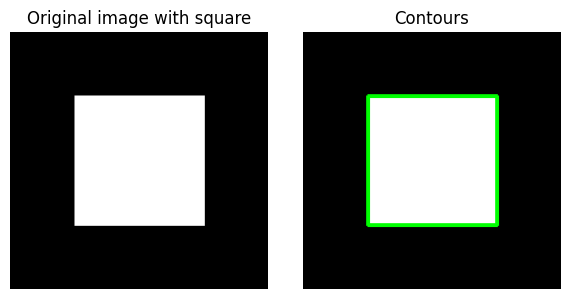

In [ ]:
# Create a blank black image
image = np.zeros((200, 200), dtype=np.uint8)

# Draw a white square in the middle
cv2.rectangle(image, (50, 50), (150, 150), 255, -1)

# Find contours in the binary image
# - image: binary image (should be a thresholded or edge-detected image)
# - mode: defines how the contours are retrieved (cv2.RETR_EXTERNAL for external contours)
# - method: specifies the contour approximation method (cv2.CHAIN_APPROX_SIMPLE)
# - contours: list of contour points, where each contour is represented as an array of points (x, y coordinates)
# - _: array that represents the hierarchical structure of contours and contains
#      information about the parent-child relationships between contours
contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Convert the original grayscale to color image
contour_image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

# Draw the contours on the original image
# - image: image on which the contours will be drawn (grayscale or color)
# - contours: list of contour points, obtained from cv2.findContours()
# - contourIdx: index of the contour to draw (-1 to draw all contours)
# - color: color for the contour
# - thickness: thickness of the contour lines (-1 to fill the contour)
# - lineType (optional): type of the contour's edge, with the following options:
#    - cv2.LINE_8: 8-connected line (default)
#    - cv2.LINE_4: 4-connected line
#    - cv2.LINE_AA: anti-aliased line
# - hierarchy (optional): information about the image topology (from cv2.findContours())
# - maxLevel (optional): maximum level for drawing contours (0 to draw only the specified contour)
# - offset (optional): offset to add to each contour point
cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)

# Print the coordinates of the contour points
print("Contour coordinates:")
for i, contour in enumerate(contours):
    print(f"\nContour {i}:")
    for point in contour:
        print(f"  {point[0]}")  # point[0] returns the (x, y) coordinates

# Display the original and the contour image
plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.title('Original image with square')
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Contours')
plt.imshow(contour_image)
plt.axis('off')

plt.tight_layout()
plt.show()

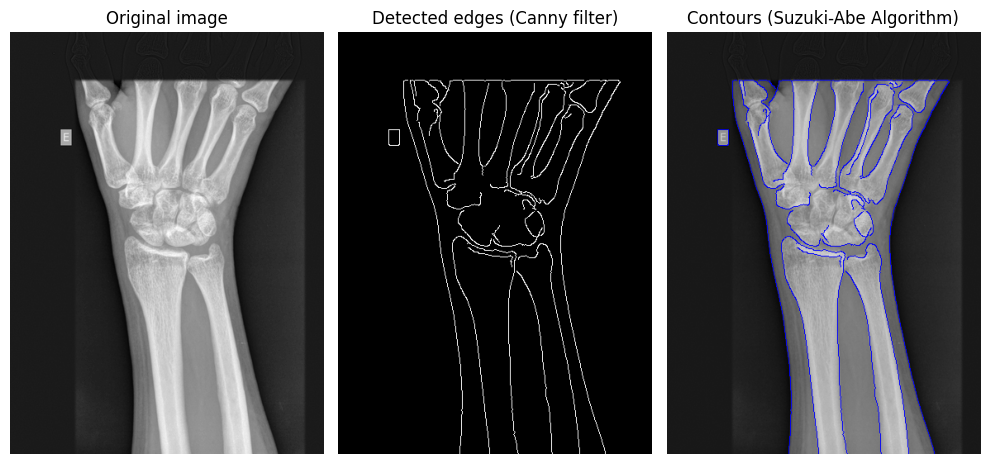

In [ ]:
# Load the grayscale image
image_path = '/content/drive/MyDrive/PIM/Images/X-ray_2.png'
grayscale_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Apply Gaussian Blur to reduce noise
blurred_image = cv2.GaussianBlur(grayscale_image, (5, 5), 0)

# Apply edge detection using Canny
edges = cv2.Canny(blurred_image, threshold1=50, threshold2=150)

# Find contours using the Suzuki-Abe algorithm
# - cv2.RETR_TREE: retrieve all of the contours and reconstruct a full hierarchy of nested contours
#	-	cv2.CHAIN_APPROX_SIMPLE: reduces the number of points, leaving only the end points
contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Convert the grayscale image to RGB to draw colored contours
contour_image = cv2.cvtColor(grayscale_image, cv2.COLOR_GRAY2RGB)

# Draw the contours on the image
cv2.drawContours(contour_image, contours, -1, (0, 0, 255), 1)  # Blue contours

# Plot the original image, detected edges, and image with contours
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(grayscale_image, cmap='gray')
plt.title('Original image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(edges, cmap='gray')
plt.title("Detected edges (Canny filter)")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(contour_image)
plt.title("Contours (Suzuki-Abe Algorithm)")
plt.axis('off')

plt.tight_layout()
plt.show()

## 4.- Active Contour Models

Active Contour Models are a broad category of techniques used in image segmentation. These models are designed to **evolve a curve** (or contour) within an image **to capture the boundaries of objects of interest**.

The evolution of the contour is driven by an **energy-minimization process** that balances different forces, guiding the contour to the desired location.

Active contour models can be classified in two main types:

* **Edge-based** active contour models (Snakes): evolve a curve by minimizing an energy function dependent on image gradients.

* **Region-based** active contour models (Chan-Vese model): the contour does not rely on gradients; it is evolved by minimizing differences in intensity between regions inside and outside the contour.

### 4.1. Chan-Vese Segmentation

Chan-Vese segmentation is a method for segmenting objects in images, particularly when the objects have **similar intensity values or the boundaries are not well-defined**.

Unlike traditional snakes that rely on image gradients (edges), the Chan-Vese model is a **region-based active contour method**. It **does not require** the object to have **strong edges**, making it more **robust to noise** and intensity variations. It works focusing on segmenting entire regions rather than just relying on edges.

In addition, the method is **less sensitive to the initial placement of the contour** and can successfully segment objects with complex shapes and varying intensities.

The algorithm works by **iteratively evolving** a contour to **minimize** an energy functional (a special type of function that receives another function as input and outputs a scalar), based on the **difference in intensity between the pixels inside (foreground) and outside (background)** the contour. The result is that the curve encloses **regions where the intensity is homogeneous**.

This makes the method effective even in cases where object boundaries are faint or incomplete and robust against noise.

The energy functional in the Chan-Vese model is defined as:

$$E(c_1, c_2, \phi) = \mu \cdot \text{Length}(\phi) + \nu \cdot \text{Area}(\text{inside}(\phi)) + \lambda_1 \cdot \int_{\text{inside}(\phi)} |I(x,y) - c_1|^2\,dx\,dy + \lambda_2 \cdot \int_{\text{outside}(\phi)} |I(x,y) - c_2|^2\,dx\,dy$$

where:

* $I(x, y)$ is the input image.
* $\phi$ is the level-set function, representing the contour.
* $c_1$ and $c_2$ are the average intensities inside and outside the contour, respectively.
* $\mu$ controls the smoothness of the contour. A higher value for $mu$ encourages smoother contours, as it penalizes longer contours, and, as a result, the contour will be fitted less tightly to the object.
* $\nu$ penalizes the area of the contour. It helps control the size of the enclosed region. A higher value of $\nu$ encourages the segmentation of smaller regions.
* $\lambda_1$ and $\lambda_2$: control the importance of fitting the contour to the region inside and outside the boundary, respectively. If the object to be segmented is darker than the background, then $\lambda_1$ should have a higher value than $\lambda_2$, and vice versa if the object is brighter.

The result of the segmentation is a **binary image** that indicates for every pixel if it is object (1, foreground) or background (0).

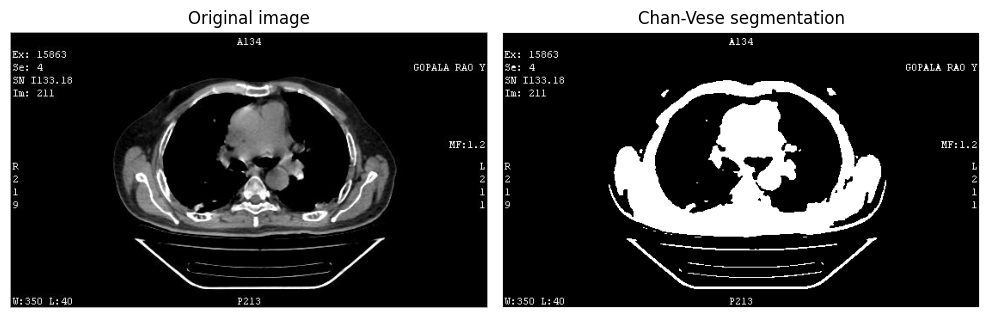

In [ ]:
from skimage.segmentation import chan_vese

# Load the grayscale image
image_path = '/content/drive/MyDrive/PIM/Images/CT_15-E.jpeg'
grayscale_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Convert the image to float32 format
grayscale_image = cv2.normalize(grayscale_image.astype('float32'), None, 0.0, 1.0, cv2.NORM_MINMAX)

# Apply Chan-Vese segmentation
# - mu: controls the smoothness of the contour (higher values result in smoother contours)
#   common values are in the range from 0.1 to 1
# - lambda1: controls the weight of the foreground (inside) region of the contour
# - lambda2: controls the weight of the background (outside) region of the contour
#   Increasing lambda1 will make the algorithm more biased towards segmenting the foreground,
#   with lambda1 < lambda2 for brighter objects in dark background
#   lambda1 = lambda2 = 1 to balance the influence; they generally range from 0.1 to 10 or more
# - tol: the tolerance for the stopping criterion (smaller values will lead to more iterations and more accurate segmentation)
#	- dt: time step, controls the rate at which the contour evolves during each iteration. A larger
#       dt value can make the contour evolve more quickly, at the cost of missing the correct segmentation
# - init_level_set: defines the starting contour for the segmentation:
#   - "checkerboard" is the default initialization pattern, good for general purpose initialization
#   - "disk": the contour starts as a disk (circular region) centered at the middle of the image;
#     it is useful when the object of interest is located near the center of the image
cv_result = chan_vese(grayscale_image, mu=0.1, lambda1=1, lambda2=3, tol=1e-3, dt=0.5, init_level_set="checkerboard")

# Plot the original image and the segmented result using subplot
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(grayscale_image, cmap="gray")
plt.title("Original image")
plt.axis("off")

# Chan-Vese segmentation result
plt.subplot(1, 2, 2)
plt.imshow(cv_result, cmap="gray")
plt.title("Chan-Vese segmentation")
plt.axis("off")

# Adjust layout
plt.tight_layout()
plt.show()

## 5.- Clustering Techniques


Clustering is an **unsupervised method** to group a set of objects or data points into a **specified number of clusters** based on their **similarity** without predefined labels.

The objects within a cluster are more similar to each other than to those in other clusters. **Clustering** can be used as a **classification technique** to group into categories, but also is used in **segmentation** to assign the different pixels an object.

### 5.1. K-Means Clustering

K-Means is a partition-based clustering algorithm that divides a dataset $Q$ into a specified number of clusters $k$. The goal is to **partition the data into $k$ groups** such that the **intra-cluster sum of squares is minimized**, where each sample **only** is assigned to **one cluster** (**hard clustering**).

This method results to be **simple and efficient**, even with large datasets, although can be very **sensitive to the choice of the number of categories and to outliers** (data points that significantly deviates from the general distribution of the data and does not fit well into any of the clusters formed by the algorithm).

Let $Q$ be form by a **set of observations** $\{\mathbf{z}_1, \mathbf{z}_2, \ldots, \mathbf{z}_Q\}$, where each vector has the form:

$$
\mathbf{z} = \begin{bmatrix}
z_1 \\
z_2 \\
\vdots \\
z_n
\end{bmatrix}
$$

1. The algorithm is **initialized** by specifying an initial set of $k$ **centroids**, $\mathbf{m}_i$ for $i = 1, 2, \dots, k$, **randomly selected**. These centroids are the **starting points** for each cluster.

2. Each sample $\mathbf{z}_q$ is assigned to **only one cluster** $C_i$, whose **mean** $\mathbf{m}_i$ is the **closest** using the Euclidean norm $\|\cdot\|$:
$$
\| \mathbf{z}_q - \mathbf{m}_i \|^2 \quad q = 1, 2, \ldots Q
$$

3. For each cluster $C_i$, **update** the mean vector $\mathbf{m}_i$ as the **average** of all points in the cluster:
$$
\mathbf{m}_i = \frac{1}{|C_i|} \sum_{\mathbf{z} \in C_i} \mathbf{z} \quad i = 1, 2, \ldots k
$$
where $|C_i|$ is the number of samples in the cluster set $C_i$.

4. Compute the **Euclidean distances** between the **current** and **previous** mean vectors, calculate the residual **error** $E$ as the sum of these distances, and **stop** if the error is lower than a specified **threshold** $T$, $E \leq T$. Otherwise, go to Step 2.

In image segmentation, the value selected for $k$ determines the **number of segmented regions**.

Shape of each cluster:  (50, 2)
Shape of the total dataset:  (150, 2)
Shape of 'labels':  (150,)
Shape of 'centroids':  (3, 2)


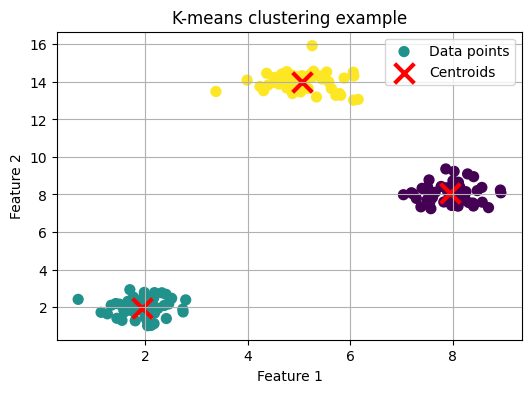

In [ ]:
from sklearn.cluster import KMeans # import KMeans module from scikit-learn

# Generate synthetic data (three clusters of data points)
np.random.seed(42) # sets the random seed to 42, which ensures that the random
                   # numbers generated by np.random.normal are reproducible
# np.random.normal generates random numbers from a normal (Gaussian) distribution
# - loc=[2, 2]: specifies the mean (center) of the normal distribution
# - scale=0.5: standard deviation of the normal distribution
# - size=(50, 2): specifies the shape of the output array (50 points, each point with 2 dimensions, x and y)
cluster_1 = np.random.normal(loc=[2, 2], scale=0.5, size=(50, 2))
cluster_2 = np.random.normal(loc=[8, 8], scale=0.5, size=(50, 2))
cluster_3 = np.random.normal(loc=[5, 14], scale=0.5, size=(50, 2))
print("Shape of each cluster: ", cluster_3.shape)

# Combine the clusters to create a dataset
data = np.vstack((cluster_1, cluster_2, cluster_3))
print("Shape of the total dataset: ", data.shape)

# Apply K-means clustering

# K-means object initialization
# - KMeans: function from the sklearn.cluster library that applies the K-means clustering algorithm
# - n_clusters=3 indicates the number of classes
# - random_state=42 sets a seed for the random number generator, ensuring that the results are reproducible
#   (the algorithm starts with the same initial centroids each time the code is run)
# - n_init=10 controls how many times the K-means algorithm is run with different
#   initializations of the cluster centroids. After the last run, the algorithm
#   will choose the solution that has the lowest within-cluster sum of squares.
#   In this way, the algorithm is less sensitive to the initial positions of the
#   centroids and it increases the likelihood of finding the global optimum.
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)

# Applies the K-means algorithm to the input data
# fit(data) means the algorithm goes through the iterative process of:
#   - initializing centroids
#   - assigning each data point to the closest centroid, which forms the initial clusters
#   - recalculating the centroids based on the mean position of the points assigned to each cluster
#   - repeating the process until the centroids stabilize, or the algorithm reaches a maximum number of iterations
# data is the dataset, formed by the patterns or intensity levels to be clustered;
#   it is a 2D array where each row represents a sample (point, or pixel in image processing),
#   and each column represents a feature of the data (for example, R, G, B components for a color image)
kmeans.fit(data)

# Get the cluster labels
# - kmeans.labels_ retrieves the assigned labels for each data point after the clustering is complete;
#   each label corresponds to the cluster number (0, 1, or 2 for 3 clusters)
labels = kmeans.labels_
print("Shape of 'labels': ", labels.shape)

# Retrieve cluster centroids
# - kmeans.cluster_centers_ retrieves the coordinates of the centroids for all the 3 clusters
#   to be used for further analysis
centroids = kmeans.cluster_centers_
print("Shape of 'centroids': ", centroids.shape)

# Plot the data points and the cluster centers
plt.figure(figsize=(6, 4))

# Plot the data points, color-coded by cluster
# data[:, 0]: 1st column, corresponds to x-axis values
# data[:, 1]: 2nd column, corresponds to y-axis values
# c=labels: sets the color of each point based on its cluster label
# cmap='hsv': colormap to be used
# marker='o': set the marker style for the data points ('o' = circular, 'x', 's' = square, ...)
# s=50: size of each marker
# label='Data points': label for the data points in the plot legend
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', marker='o', s=50, label='Data points')

# Plot the centroids
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=200, linewidths=3, label='Centroids')

# Add labels and title
plt.title('K-means clustering example')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()

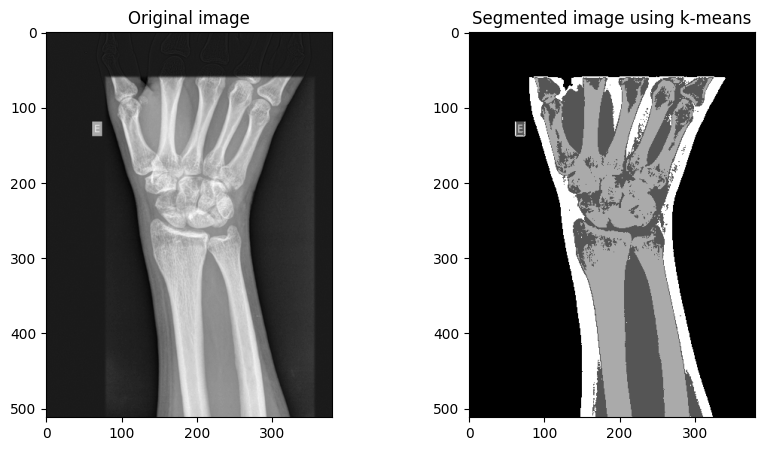

In [ ]:
from sklearn.cluster import KMeans

# Load the grayscale image
image_path = '/content/drive/MyDrive/PIM/Images/X-ray_2.png'
grayscale_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Prepare the data for K-means clustering
# .reshape(-1, 1) flattens the image into a 2D array where each pixel value is a feature
# -1 tells NumPy to infer the size of that dimension based on the total number of elements in the array
# 1 makes the reshaped array have one column; the flattened pixel values are
#   arranged into a 2D array of size (height * width, 1)
pixel_values = grayscale_image.reshape(-1, 1)

# Apply k-means clustering
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
kmeans.fit(pixel_values)

# Get the labels for each pixel
labels = kmeans.labels_

# Reshape the labels to the original image shape
segmented_image_kmeans = labels.reshape(grayscale_image.shape)

# Plot the original and segmented images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(grayscale_image, cmap='gray')
plt.title('Original image')

plt.subplot(1, 2, 2)
plt.imshow(segmented_image_kmeans, cmap='gray')
plt.title('Segmented image using k-means')

plt.show()

The resulting 'image' is not formed by intensity values, but for the **labels** of the clusters.

In [ ]:
print(segmented_image_kmeans.shape)
print(segmented_image_kmeans[50:70,100:120])

(512, 380)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0]
 [1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3]
 [1 1 1 1 2 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3]
 [1 1 1 1 1 2 2 1 1 1 3 3 3 3 3 3 3 3 3 3]
 [1 1 1 1 1 1 2 1 1 1 1 3 3 3 3 3 3 3 3 3]
 [1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3]
 [1 1 1 1 1 1 1 1 2 1 1 1 1 3 3 3 3 3 3 3]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 3]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3]]


Finally, the resulting **centroids** represent the **average intensity** of each group (for labels $0, 1, \ldots, k$).

In [ ]:
# Retrieve the centroids
centroids = kmeans.cluster_centers_
print("Centroids (average intensity of each group):")
print(centroids)

Centroids (average intensity of each group):
[[ 28.30459535]
 [131.11061964]
 [175.85634065]
 [ 98.3092265 ]]


### 5.2. Fuzzy C-Means

Fuzzy C-Means (FCM) is a clustering algorithm that allows one sample to **belong to two or more clusters (soft clustering)**.

This algorithm is based on **minimizing an objective function** (similar to the k-means algorithm), but it introduces the concept of **fuzzy membership**, where each data point has a **degree of belonging to each cluster**, as opposed to a hard assignment as seen in k-means.

The **goal** of FCM is to **find cluster centers** (centroids) that **minimize the dissimilarity** of the points within each cluster **while considering the “fuzziness”** of the cluster boundaries.

The degree of belonging for each data point to a given cluster is expressed as a **membership grade**, typically between 0 and 1, indicating how closely the data point is related to that cluster.

The FCM algorithm has some **similarities** with k-means algorithm:

Let consider a **dataset** $Q = \{\mathbf{z}_1, \mathbf{z}_2, \dots, \mathbf{z}_Q\}$

1. The algorithm **initializes** by choosing the number of clusters $k$, a fuzziness parameter $m > 1$ (which controls the level of cluster fuzziness; the larger the value of $m$, the fuzzier the clusters are), and a termination criterion $T$. It also initializes the **membership matrix** $\mathbf{U}$ randomly such that:
$$
u_{ij} = \frac{1}{\sum_{l=1}^k \left(\frac{\|\mathbf{z}_i - \mathbf{m}_j\|}{\|\mathbf{z}_i - \mathbf{m}_l\|}\right)^{\frac{2}{m-1}}}
$$
where $u_{ij}$ is the membership of $\mathbf{z}_i$ in cluster  $j$ (with $\sum_{j=1}^k u_{ij} = 1$), $\mathbf{m}_j$ is the centroid of cluster $j$, and $\|\cdot\|$ represents the Euclidean norm.

2. **Update the centroids**, by calculating the cluster centers $\mathbf{m}_j$ for each cluster $j$ using the membership matrix:
$$
\mathbf{m}_j = \frac{\sum_{i=1}^Q u_{ij}^m \mathbf{z}_i}{\sum_{i=1}^Q u_{ij}^m}
$$
where the sum is over all data points $i$ for the $j$-th cluster, and $u_{ij}^m$ weights the contribution of each data point $\mathbf{z}_i$ to the centroid $\mathbf{m}_j$ based on its membership degree.

3. **Update the membership values** $u_{ij}$ using the new cluster centers $\mathbf{m}_j$:
$$
u_{ij} = \frac{1}{\sum_{l=1}^k \left(\frac{\|\mathbf{z}_i - \mathbf{m}_j\|}{\|\mathbf{z}_i - \mathbf{m}_l\|}\right)^{\frac{2}{m-1}}}
$$

4. **Check the convergence** of the algorithm, by computing the **objective function** $J$:
$$
J = \sum_{i=1}^Q \sum_{j=1}^k u_{ij}^m \|\mathbf{z}_i - \mathbf{m}_j\|^2
$$
If the change in the objective function $J$ between iterations is less than the termination criterion $T$, the algorithm **stops**. Otherwise, return to Step 2.

In [ ]:
!pip install scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 21.8 MB/s eta 0:00:00


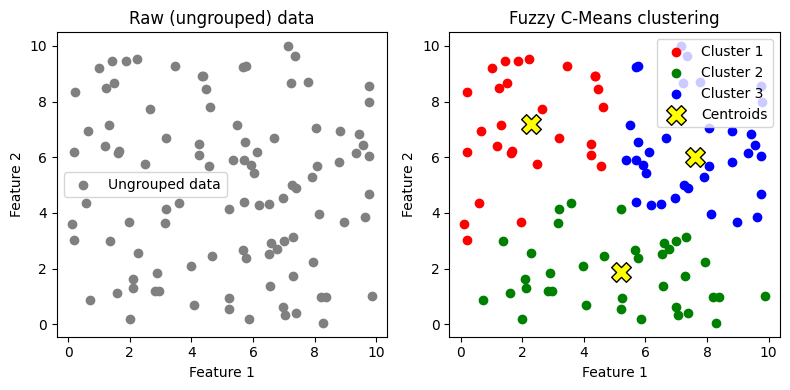

In [ ]:
import skfuzzy as fuzz # import scikit-fuzzy

# Generate random data
np.random.seed(0)  # sets the random seed to 0
data = np.random.rand(100, 2) * 10  # generates 100 random points in a 2D space,
                                    # where each coordinate (x, y) is between 0 and 10

# Fuzzy C-Means parameters
n_clusters = 3  # number of clusters
m = 2.0 # fuzziness parameter

# Apply Fuzzy C-Means clustering
#
# Input parameters:
# - data.T: transposed dataset (FCM format), meaning each row represents a feature,
#   and each column is a data point
# - n_clusters: number of clusters
# - m: fuzziness parameter (or fuzzification exponent); controls the fuzziness of the
#   clustering process. A value of m=2 is commonly used. The larger the value of m,
#   the fuzzier the clustering will be.
# - error=0.005: stopping criterion for the algorithm (when the improvement between
#   two iterations is less than this value)
# - maxiter=1000: maximum number of iterations the algorithm is allowed to run
# - init=None: specifies the initial membership matrix. If None, the algorithm starts
#   with a random initialization
#
# Output Variables:
#	- cntr: final cluster centers (centroids)
# - u: final fuzzy membership matrix; contains the membership degrees of each data
#   point to each cluster. The values in each row sum to 1.
# - u0: initial fuzzy membership matrix (initial assignment of points to clusters, usually random)
# - d: distances between each data point and the cluster centers
# - jm: objective function (cost function) values for each iteration
# - p: represents the number of iterations the algorithm has to run before stopping
# - fpc: fuzzy partition coefficient (between 0 and 1); measure of the “fuzziness”
#   of the solution (1 means the clustering is more crisp (less fuzzy))
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(data.T, n_clusters,
                                          m, error=0.005, maxiter=1000, init=None)

# Assign each data point to the cluster with the highest membership value
# u: membership matrix from Fuzzy C-Means. Each column represents the membership
#    of a data point across all clusters.
# np.argmax(u, axis=0): returns the index of the maximum value along a specified axis.
# axis=0: tells NumPy to operate along the columns of u. For each data point
#    (each column), it will look at the membership values across all clusters
#    and return the index (or cluster number) with the highest membership
# cluster_membership: stores the cluster index to which each data point most likely belongs,
#    based on the highest membership value
cluster_membership = np.argmax(u, axis=0)

# Create a figure with subplots
plt.figure(figsize=(8, 4))

# Subplot 1: raw data before clustering
plt.subplot(1, 2, 1)
plt.scatter(data[:, 0], data[:, 1], color='gray', label='Ungrouped data')
plt.title('Raw (ungrouped) data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

# Subplot 2: clustered data after Fuzzy C-Means
plt.subplot(1, 2, 2)
colors = ['r', 'g', 'b']
for i in range(n_clusters):
    # Plot only the points belonging to the current cluster
    plt.scatter(data[cluster_membership == i, 0], data[cluster_membership == i, 1],
                color=colors[i], label=f'Cluster {i+1}')
# Plot the cluster centers
plt.scatter(cntr[:, 0], cntr[:, 1], s=200, c='yellow', edgecolors='k', marker='X', label='Centroids')
plt.title('Fuzzy C-Means clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

Centroids (average intensity of each group):
[[ 28.30459535]
 [131.11061964]
 [175.85634065]
 [ 98.3092265 ]]
Fuzzy Partition Coefficient: 0.89


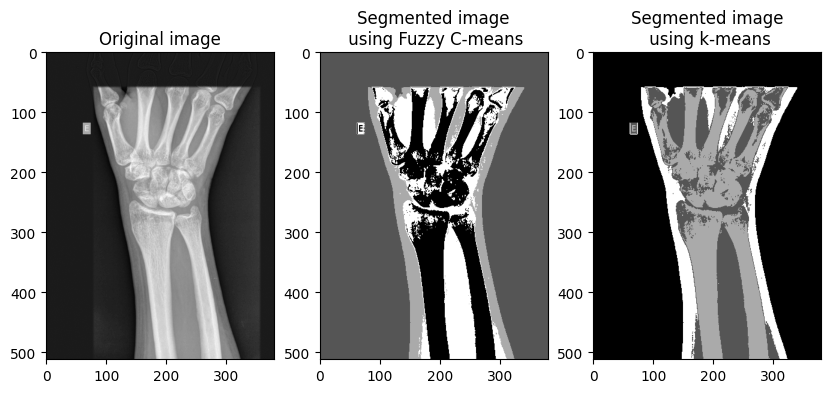

In [ ]:
import skfuzzy as fuzz

# Load the grayscale image
image_path = '/content/drive/MyDrive/PIM/Images/X-ray_2.png'
grayscale_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Prepare the data for Fuzzy C-means clustering
# Flatten the image into a 2D array of size (height * width, 1)
pixel_values = grayscale_image.reshape((-1, 1))
pixel_values = pixel_values.T  # Transpose the pixel values for skfuzzy

# Fuzzy C-Means parameters
n_clusters = 4  # number of clusters
m = 2.0 # fuzziness parameter

# Apply Fuzzy C-means clustering
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(pixel_values, n_clusters,
                                        m, error=0.005, maxiter=1000, init=None)
print("Centroids (average intensity of each group):")
print(centroids)
print(f"Fuzzy Partition Coefficient: {fpc:.2f}")

# Assign clusters based on maximum membership
cluster_membership = np.argmax(u, axis=0)

# Reshape the labels to the original image shape
segmented_image_fcm = cluster_membership.reshape(grayscale_image.shape)

# Plot the original and segmented images
plt.figure(figsize=(10, 6))

plt.subplot(1, 3, 1)
plt.imshow(grayscale_image, cmap='gray')
plt.title('Original image')

plt.subplot(1, 3, 2)
plt.imshow(segmented_image_fcm, cmap='gray')
plt.title('Segmented image\n using Fuzzy C-means')

plt.subplot(1, 3, 3)
plt.imshow(segmented_image_kmeans, cmap='gray')
plt.title('Segmented image\n using k-means')

plt.show()

## 6.- Region-Based Segmentation


### 6.1. Watershed Segmentation

The _watershed_ algorithm is an image segmentation technique that divides an image into different regions based on the **topology of its intensity values**. The algorithm is useful for segmenting images with **overlapping objects** or where the **boundaries** between objects are **not clearly defined**.

The watershed algorithm treats an image like a **topographic surface**, where **pixel intensity** represents the **height** of the surface. The concept is inspired by how water flows across a landscape, filling basins (**local minima**) with ridges (**watersheds**) between them.

In image processing, these basins correspond to **regions of similar intensity**, and the watersheds define the **boundaries between them**. The algorithm floods the surface from its minima, and when water from different basins would merge, a dam (**watershed line**) is built to prevent this, defining the **region boundaries**.

<img src="https://www.researchgate.net/publication/349323744/figure/fig2/AS:991524607258625@1613409296245/The-segmentation-process-of-the-watershed-algorithm.ppm" alt="Caption" width="800">
<p style="text-align: center;">Figure 8: Segmentation process of the watershed algorithm. Source: <a href="https://www.researchgate.net/figure/The-segmentation-process-of-the-watershed-algorithm_fig2_349323744">ResearchGate.com.</a></p>

The basic **steps** of the algorithm are as follows:

1. The input image is often **preprocessed** to enhance the regions of interest (filtering, edge detection, ...).
2. Markers (**initial points**) are selected within each region to be segmented. These markers can be identified manually, using morphological operations, or by finding local minima in the gradient image.
3. The **image is flooded starting from the markers**. As the water level rises, pixels are added to the basins corresponding to their nearest marker. When **water from different basins meets** at step $n$, **watershed lines are formed** (so the algorithm stops at the previous step $n-1$).
4. The final output of the algorithm is a **labeled image** where each region corresponds to a basin, and the boundaries between regions are the watershed lines.

The **input** to the watershed algorithm is a **gradient image**, where each pixel's value represents the magnitude of the intensity gradient, **emphasizing edges**. The gradient magnitude image is computed as:

$$G(x, y) = \sqrt{\left(\frac{\partial I(x, y)}{\partial x}\right)^2 + \left(\frac{\partial I(x, y)}{\partial y}\right)^2}$$

where $I(x, y)$ represents the intensity of the image at pixel $(x, y)$. **Gradient operators**, such as Sobel or Prewitt, are commonly applied to obtain this gradient image, highlighting the transitions between different regions.

The algorithm detects regions in the image that are **most likely to belong** to the foreground and background.

The foreground corresponds to the **central areas** of the objects, which serve as the **seeds** (markers) from which the algorithm begins flooding during the segmentation process.

The background represents the areas that are farthest from the objects.

This leaves the regions **near the edges** of the shapes as the **difference or unknown regions**, where the algorithm is uncertain whether they belong to the foreground or background. It is in this unknown region that the actual watershed lines, which define the boundaries between objects, will be determined.

The watershed algorithm will analyze the unknown areas to delineate the boundaries between the overlapping objects. The result is a **segmentation that separates the objects, even where they overlap**, by placing watershed lines along the ridges of the intensity landscape.

Maximum distance:  24.768995


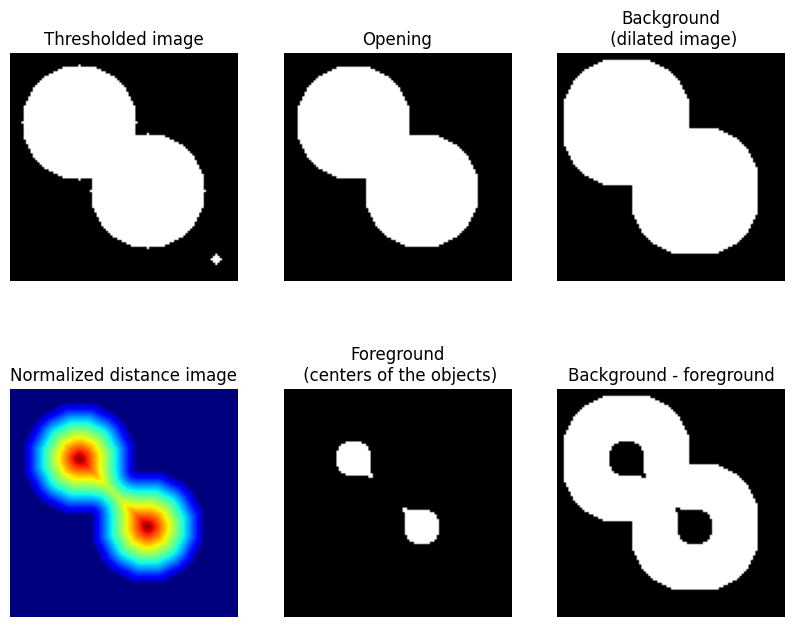

In [ ]:
# Create a synthetic binary image with overlapping shapes
image = np.zeros((100, 100), dtype=np.uint8)
cv2.circle(image, (30, 30), 25, 255, -1)  # Draw a white circle
cv2.circle(image, (60, 60), 25, 255, -1)  # Draw a white circle
cv2.circle(image, (90, 90), 2, 255, -1)  # Noise

# Apply Otsu's thresholding to binarize the image
# Parameters:
# - src: input image (grayscale image)
# - thresh: threshold value (ignored with THRESH_OTSU)
# - maxval: maximum value to use with binary thresholding (255 means white)
# - type: thresholding type (THRESH_BINARY + THRESH_OTSU)
_, thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Noise removal using morphological opening
# Parameters:
# - src: input image (binarized image from thresholding)
# - op: type of morphological operation (MORPH_OPEN for erosion followed by dilation)
# - kernel: structuring element (3x3 matrix of ones)
# - iterations: number of times the operation is applied (2 times)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# Finding background area by dilating the image
# Parameters:
# - src: input image (opened image)
# - kernel: structuring element (3x3 matrix of ones)
# - iterations: number of times the dilation is applied (3 times)
# This step helps identify the areas that are background
bg = cv2.dilate(opening, kernel, iterations=3)

# Finding foreground area using distance transform

# Convert a binary image ('opening') into an image where the value of each pixel
# represents the distance from that pixel to the nearest pixel that belongs to
# the background (value of 0, or “black”).
# Parameters:
# - src: input image (opened image)
# - distanceType: type of distance (DIST_L2 means Euclidean distance)
# - maskSize: size of the mask (5 indicates a 5x5 mask for calculating the distance transform)
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
print("Maximum distance: ", np.max(dist_transform))

# Normalize the distance image for display
# Parameters:
# - src: input image (distance transform image)
# - dst: output normalized image (None means in-place normalization)
# - alpha: lower range boundary (0 indicates the minimum value)
# - beta: upper range boundary (255 indicates the maximum value)
# - norm_type: normalization type (NORM_MINMAX scales the values to fit within the range [alpha, beta])
dist_transform_norm = cv2.normalize(dist_transform, None, 0, 255, cv2.NORM_MINMAX)

# Threshold the distance transform image to get the foreground
# Parameters:
# - src: input image (normalized distance transform image)
# - thresh: threshold value (0.7 * dist_transform.max() selects pixels with values >= 70% of the maximum)
# - maxval: maximum value to use with binary thresholding (255 means white)
# - type: thresholding type (THRESH_BINARY selects pixels >= thresh)
_, fg = cv2.threshold(dist_transform_norm, 0.7 * dist_transform_norm.max(), 255, 0)

# Convert foreground to uint8 format (required for the next steps)
fg = np.uint8(fg)

# Find difference region by subtracting foreground from background to identify
# areas that are not clearly part of either the foreground or background
difference = cv2.subtract(bg, fg)

plt.figure(figsize=(10, 8))

plt.subplot(2, 3, 1)
plt.imshow(thresh, cmap='gray')
plt.title('Thresholded image')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(opening, cmap='gray')
plt.title('Opening')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(bg, cmap='gray')
plt.title('Background\n (dilated image)')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(dist_transform_norm, cmap='jet', vmin=0, vmax=255)
plt.title('Normalized distance image')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(fg, cmap='gray')
plt.title('Foreground\n (centers of the objects)')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(difference, cmap='gray')
plt.title('Background - foreground')
plt.axis('off')

plt.show()

[[ 2  2  2  2  2  2  2  2  2  2]
 [ 2  2  2  2  2  2  2  2  2 -1]
 [ 2  2  2  2  2  2  2  2 -1  3]
 [ 2  2  2  2  2  2  2 -1  3  3]
 [ 2 -1 -1 -1 -1 -1 -1  3  3  3]
 [-1  1  1  1  1  1 -1  3  3  3]
 [ 1  1  1  1  1  1 -1  3  3  3]
 [ 1  1  1  1  1  1 -1  3  3  3]
 [ 1  1  1  1  1  1 -1  3  3  3]
 [ 1  1  1  1  1  1 -1  3  3  3]]


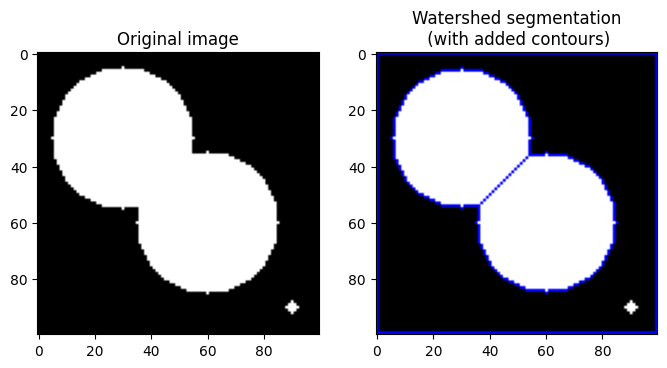

In [ ]:
# Marker labeling
# Label connected components in a binary image: each connected region is given a unique label
# cv2.connectedComponents(fg) scans the input binary image and labels each connected region
# with a different label (a unique integer value): 0 (background), 1, 2, 3, ...
# The function returns two values:
# - number of labels (ignored)
# - markers: labeled image, where each pixel is assigned a label
_, markers = cv2.connectedComponents(fg)

# Add one to all labels so that the background is not 0, but 1
# This reserves label 0 for the difference region (background - foreground)
markers = markers + 1
markers[difference == 255] = 0. # mark the region of unknown with zero

# Convert the original image to color to add the object contours
segmented_image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

# Apply the Watershed algorithm to the original image using the markers
# - image: original input image (color or grayscale)
# - markers: 2D image that contains the initial markers (or labels):
#   · Background pixels: labeled as 1
#   · Foreground objects: labeled as 2, 3, ...
#   · Difference (unknown/undefined): marked with 0
# Return value:
# - markers: after the algorithm is applied, the markers array is modified and returned
#  	as a 2D array with the labeled regions for each pixels, marking with -1 those
#   pixels that define the boundaries between the segmented regions
markers = cv2.watershed(segmented_image, markers)
print(markers[50:60, 30:40])

# Mark the watershed regions in red
# markers == -1: creates a Boolean mask with the pixels that delimite regions
# Color these pixels in blue (RGB: [0, 0, 255])
segmented_image[markers == -1] = [0, 0, 255]

# Plot the results
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original image')

plt.subplot(1, 2, 2)
plt.imshow(segmented_image)
plt.title('Watershed segmentation\n (with added contours)')

plt.show()

Maximum distance:  14.984499


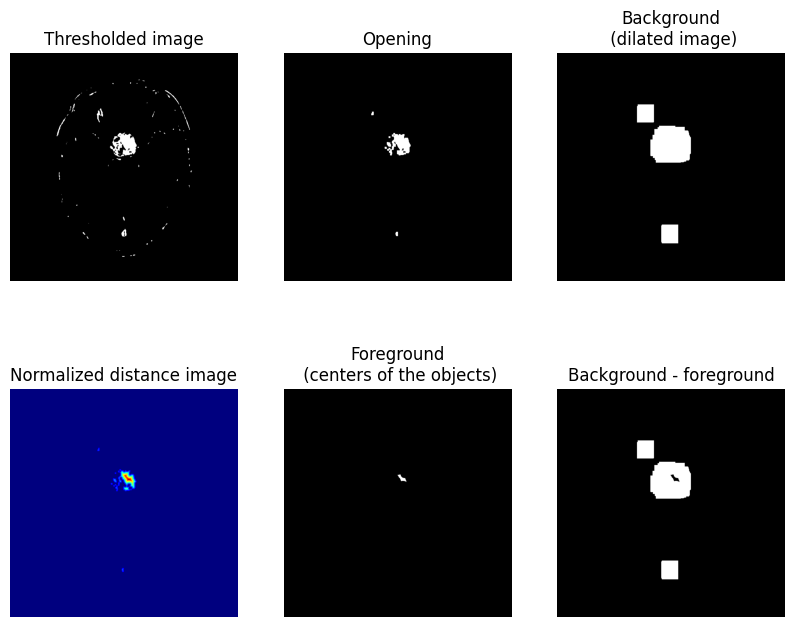

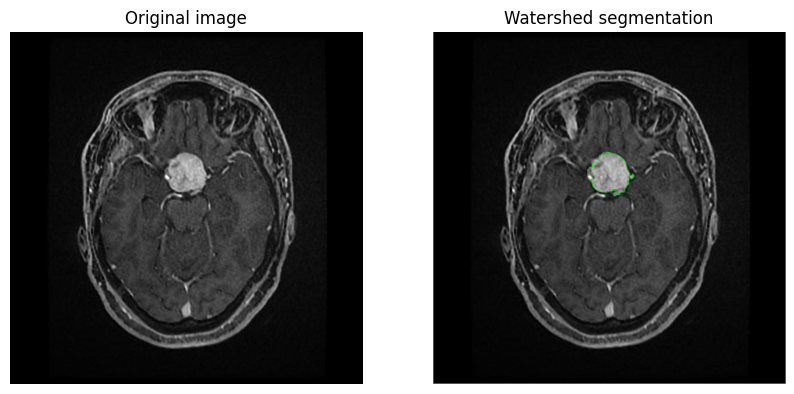

In [ ]:
# Load a grayscale image
image_path = '/content/drive/MyDrive/PIM/Images/meningioma_294.jpeg'
grayscale_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Apply thresholding to binarize the grayscale image
_, thresh = cv2.threshold(grayscale_image, 150, 255, cv2.THRESH_BINARY)

# Noise removal using morphological opening
# A kernel (structuring element) of size 3x3 is used to remove noise by
# first eroding the image, then dilating it (opening)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# Find background area by dilating the opened image (expanding the background areas)
bg = cv2.dilate(opening, kernel, iterations=20)

# Find foreground area using distance transform and normalize the distance
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
print("Maximum distance: ", np.max(dist_transform))
dist_transform_norm = cv2.normalize(dist_transform, None, 0, 255, cv2.NORM_MINMAX)

# Threshold the distance transform image to get the foreground
# The value 0.7 * max value is intended to ensure that only the central parts of
# the objects are considered as the foreground
_, fg = cv2.threshold(dist_transform_norm, 0.7 * dist_transform_norm.max(), 255, 0)
fg = np.uint8(fg)

# Finding the difference (unknown) region, as the subtraction of fg from bg
difference = cv2.subtract(bg, fg)

# Display intermediate results
plt.figure(figsize=(10, 8))

plt.subplot(2, 3, 1)
plt.imshow(thresh, cmap='gray')
plt.title('Thresholded image')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(opening, cmap='gray')
plt.title('Opening')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(bg, cmap='gray')
plt.title('Background\n (dilated image)')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(dist_transform_norm, cmap='jet', vmin=0, vmax=255)
plt.title('Normalized distance image')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(fg, cmap='gray')
plt.title('Foreground\n (centers of the objects)')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(difference, cmap='gray')
plt.title('Background - foreground')
plt.axis('off')

plt.show()

# Label connected components in a binary image: each connected region is given a unique label
_, markers = cv2.connectedComponents(fg)

# Increment all labels so that the background is labeled as 1, instead of 0
markers = markers + 1

# Mark the difference (unknown) region as 0 in the markers image
markers[difference == 255] = 0

# Apply the Watershed algorithm to the original image using the markers
# Watershed lines (boundaries) are marked with a value of -1
segmented_image = np.uint8(cv2.cvtColor(grayscale_image, cv2.COLOR_GRAY2RGB))
markers = markers.astype(np.int32) # convert markers to 32-bit signed integer
markers = cv2.watershed(segmented_image, markers)

# Mark the watershed boundaries with green color
segmented_image[markers == -1] = [0, 255, 0]

# Plot the results
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(grayscale_image, cmap='gray')
plt.title('Original image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(segmented_image)
plt.title('Watershed segmentation')
plt.axis('off')

plt.show()

## References

* González, Rafael C., _Digital image processing: Chapter 10 (Image Segmentation)_. Prentice Hall,. 2018. 9780132345637

* Chityala, Ravishankar, _Image Processing and Acquisition Using Python: Chapters 8 (Segmentation)_. Chapman and Hall/CRC, 2022. 9780367531577

* Toennies, Klaus D., _Guide to Medical Image Analysis - Methods and Algorithms: Chapters 6 (Segmentation: Principles and Basic Techniques) and 7 (Segmentation in Feature Space)_. Springer, 2017. 9781447174035

* Birkfellner, Wolfgang, _Applied Medical Image Processing - A Basic Course: Chapters 6 (Segmentation)_. CRC Press, 2014. 9781466555570




